# تحميل (استيراد) المكتبات الأساسية
# Importing

In [8]:
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import parse_time
import numpy as np

# الفترة الزمنية لدراسة التوهج الشمسى
# Solar Flare period

# 

In [9]:
# Define time range
tr = a.Time('2023-12-14 00:00', '2023-12-15 00:00')

# استخلاص البيانات
# Getting Data

In [10]:
# Query GOES XRS with minimal working filters
goes_results = Fido.search(tr, a.Instrument.xrs & a.goes.SatelliteNumber(16))
goes_file = Fido.fetch(goes_results)[0]
goes = ts.TimeSeries(goes_file).to_dataframe()

# Query HEK flares separately
hek_results = Fido.search(tr, a.hek.FL & (a.hek.FRM.Name == 'SWPC'))['hek']

Files Downloaded: 100%|██████████| 4/4 [00:00<00:00,  8.58file/s]


# Visualization العرض

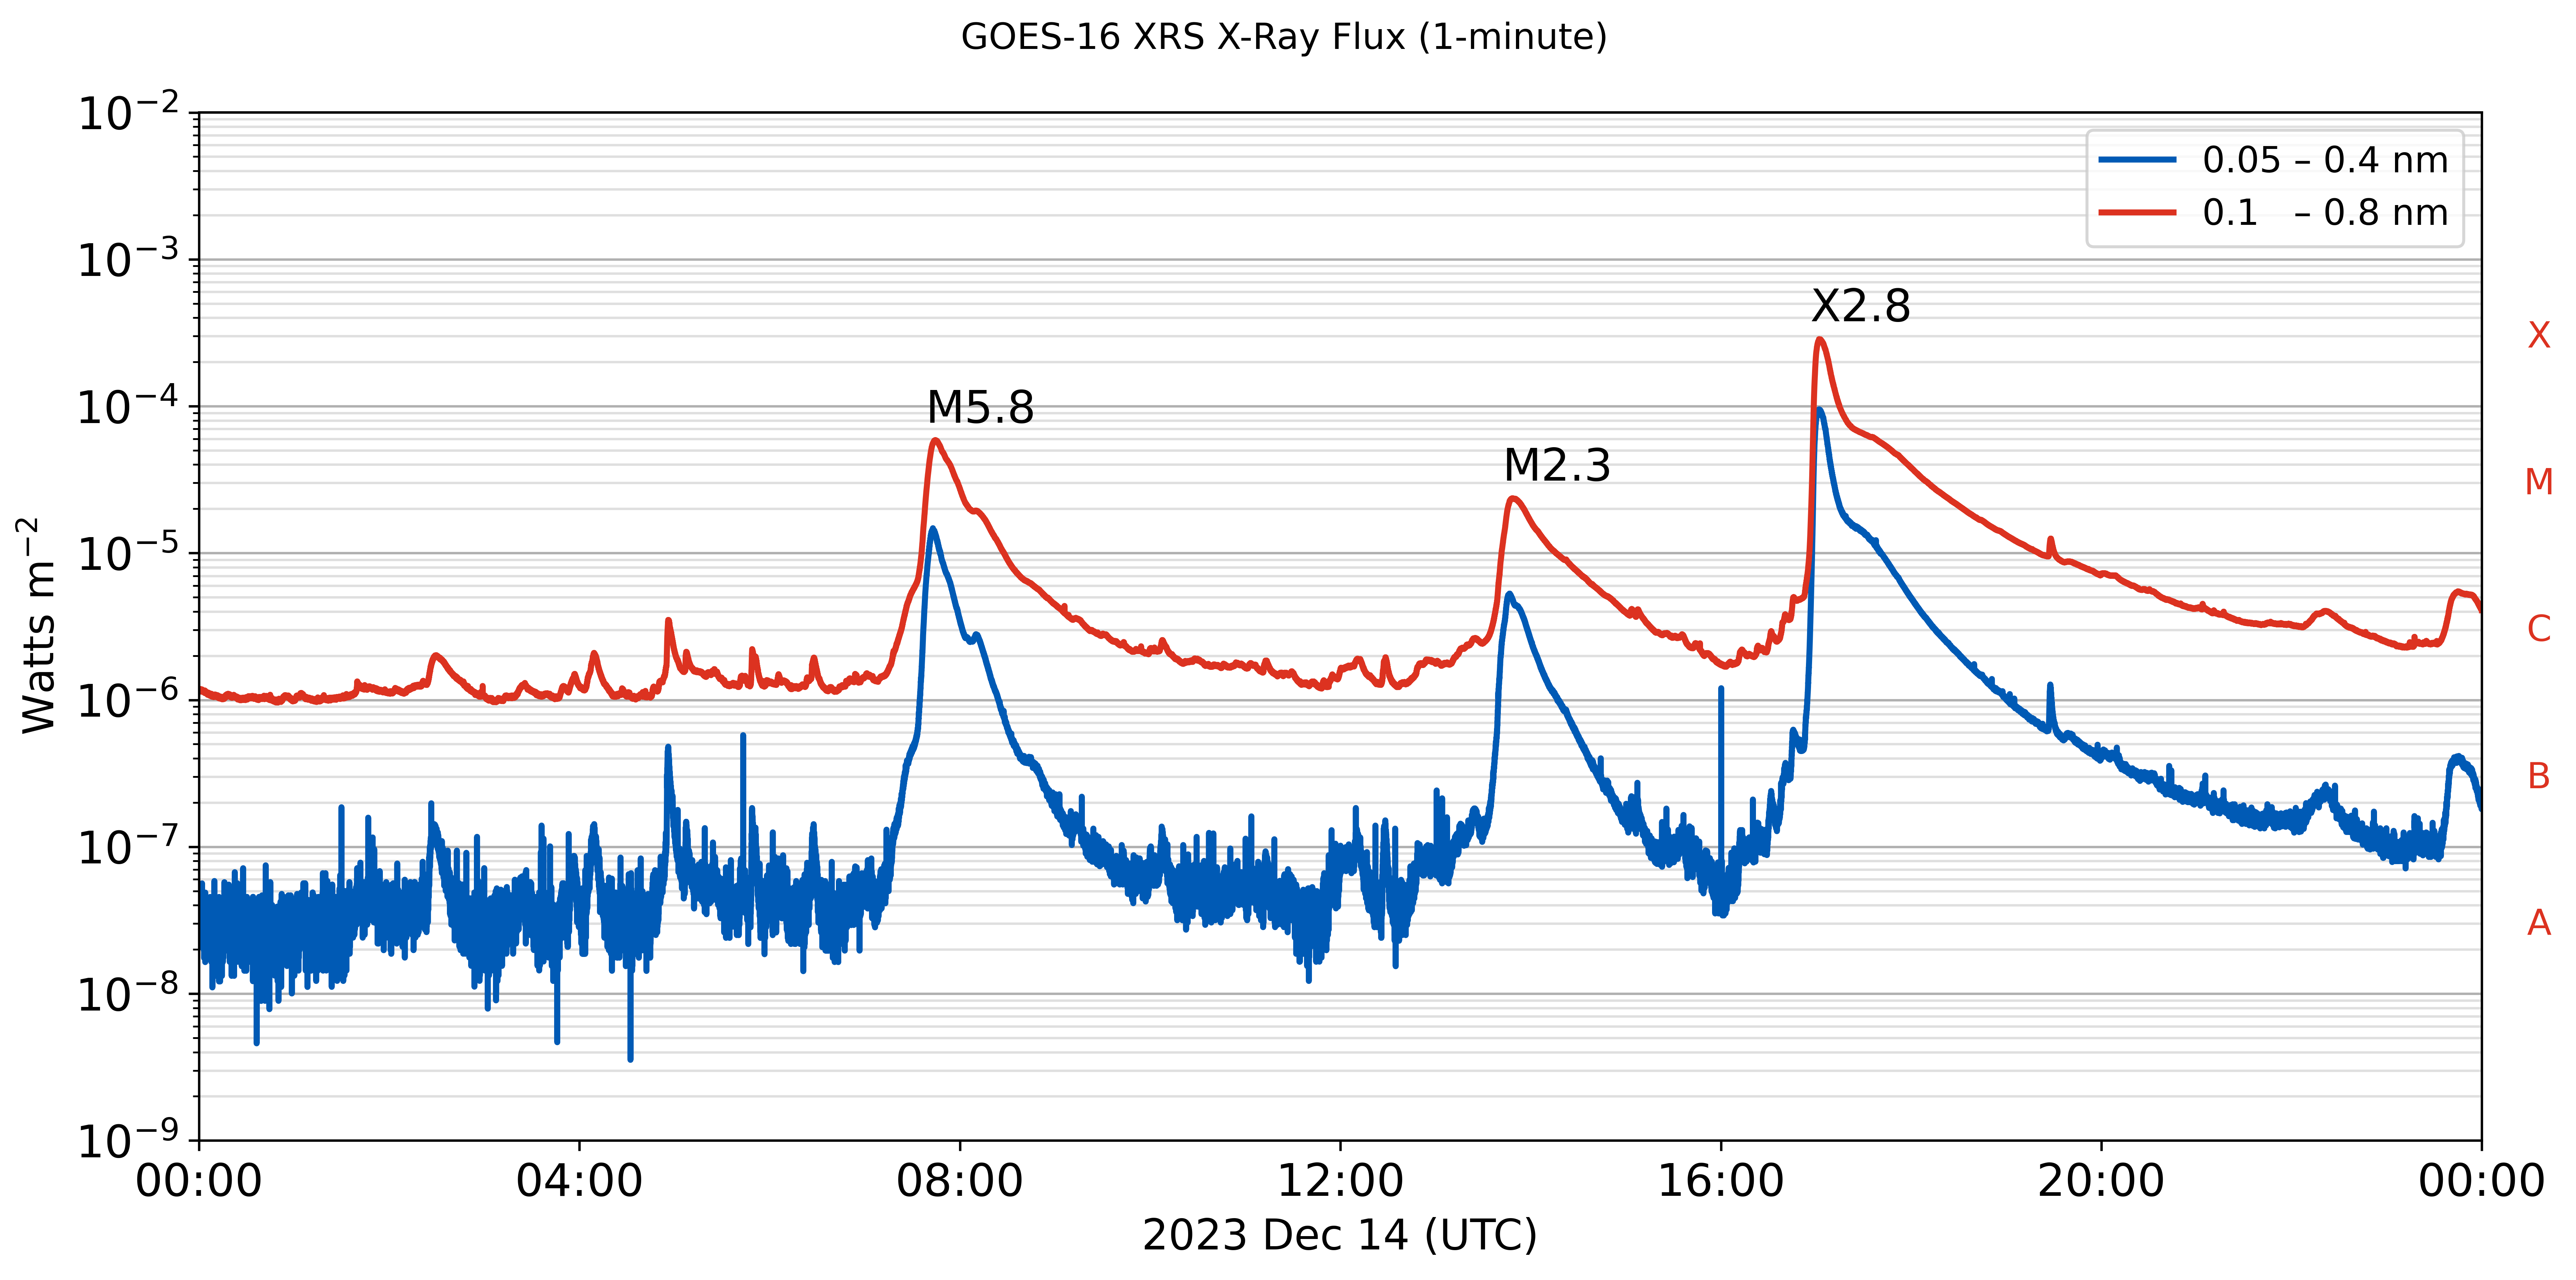

In [14]:
# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), dpi=600)
fig.suptitle("GOES-16 XRS X-Ray Flux (1-minute)")

# Plot XRS short and long wavelength channels
ax.plot(goes.index, goes['xrsa'], label='0.05 – 0.4 nm', color='#005AB5', linewidth=2)
ax.plot(goes.index, goes['xrsb'], label='0.1   – 0.8 nm', color='#DC3220', linewidth=2)

# Add soft X-ray classification labels
sxr_labels = ['A', 'B', 'C', 'M', 'X']
flux_levels = np.logspace(-7.6, -3.6, len(sxr_labels))
for flux, label in zip(flux_levels, sxr_labels):
    ax.text(1.025, flux, label, transform=ax.get_yaxis_transform(),
            ha='center', fontsize='large', color='#DC3220')

# Annotate M- and X-class flares from HEK results
for flare in hek_results:
    classification = flare.get('fl_goescls', '')
    if 'M' in classification or 'X' in classification:
        try:
            peak_time = parse_time(flare['event_peaktime']).datetime
            idx = goes.index.get_indexer([peak_time], method='nearest')[0]
            peak_value = goes['xrsb'].iloc[idx]
            ax.annotate(classification, (goes.index[idx], peak_value), (-3, 6),
                        textcoords='offset points', color='black', fontsize=15)
        except Exception as e:
            print(f"Flare annotation failed: {e}")

# Axis settings and formatting
ax.set_yscale("log")
ax.set_ylim(1e-9, 1e-2)
ax.set_xlim(tr.start.to_datetime(), tr.end.to_datetime())

ax.set_ylabel("Watts m$^{-2}$", fontsize=14)
ax.set_xlabel("2023 Dec 14 (UTC)", fontsize=14)
ax.tick_params(labelsize=15)

ax.grid(True, which='major', axis='y', alpha=1.0)
ax.grid(True, which='minor', axis='y', alpha=0.4)

ax.xaxis.set_major_locator(HourLocator(byhour=range(0, 24, 4)))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Add normal legend in upper right corner
ax.legend(loc='upper right', fontsize=12)

# Final layout adjustments
plt.tight_layout()
plt.show()
